# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** B

**Names:**

* Vincenzo Bazzucchi
* Amaury Combes
* Alexis Montavon

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from collections import Counter
%matplotlib inline

In [2]:
def directed_graph_from_tsv(pathname):
    """Reads graph from tsv file"""
    file = open(pathname, 'r');
    G = nx.DiGraph()
    for line in file:
        content = line.split('\t')
        u = int(content[0])
        adjacent_nodes = map(lambda v: int(v), content[1].split())
        for v in adjacent_nodes:
            G.add_edge(u, v)
    file.close()
    return G

In [3]:
def random_surfer(G, max_hops=1000):
    counter = Counter()
    u = choice(G.nodes())
    counter[u] += 1
    for i in range(max_hops):
        links = list(G[u].keys())
        if len(links) == 0: # Dangling node found!
            break
        v = choice(links)
        counter[v] += 1
        u = v
    n = sum(counter.values())
    return {page: counter[page] / n for page in counter.keys()}

In [4]:
components = directed_graph_from_tsv('../data/components.graph')
absorbing = directed_graph_from_tsv('../data/absorbing.graph')

In [5]:
N_SIMUL = 100
visited_nodes_p = 0
for i in range(N_SIMUL):
    visited_nodes_p += len(random_surfer(components))
print((visited_nodes_p / N_SIMUL) * 100 / len(components), '% of nodes was visited in average')

50.0 % of nodes was visited in average


In [6]:
N_SIMUL = 100
visited_nodes_p = 0
for i in range(N_SIMUL):
    visited_nodes_p += len(random_surfer(absorbing))
print((visited_nodes_p / N_SIMUL)* 100 / len(absorbing), '% of nodes was visited in average')

46.39999999999999 % of nodes was visited in average


We observe that even if the number of maximal hops is quite large, we only visit half the graph. We can imagine that both graphs are actually compose of two big cluster (two giant components) or have dangling nodes.

Here we can see that the components graph has 2 connected components


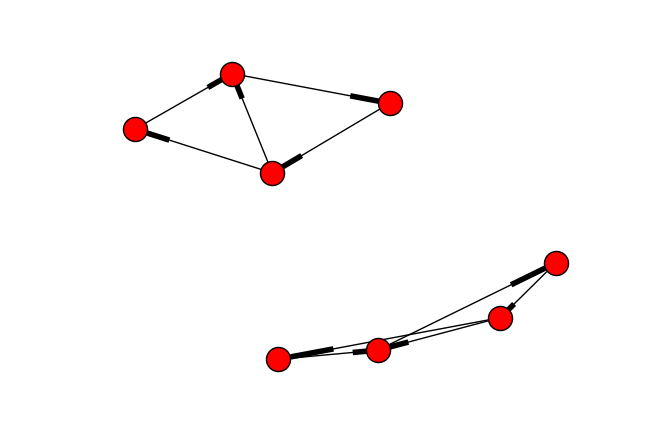

In [7]:
nx.draw(components)
print("Here we can see that the components graph has 2 connected components")

In the absorbing graph we can see that node 1 is indeed absorbing, which explains why we never visit more than 60% of the graph


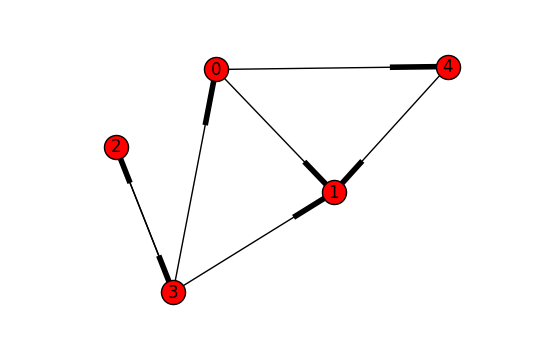

In [8]:
nx.draw_networkx(absorbing, labels={x: x for x in absorbing.nodes()})
plt.axis("off")
print("In the absorbing graph we can see that node 1 is indeed absorbing, which explains why we never visit more than 60% of the graph")

#### Exercise 2.13

In [9]:
def random_surfer_improved(G, max_hops=1000, damping_factor=0.15):
    counter = Counter()
    u = choice(G.nodes())
    counter[u] += 1
    for i in range(max_hops):
        links = list(G[u].keys())
        # if restart or dangling node start at random
        if np.random.binomial(1, damping_factor) or len(links) == 0:
            v = choice(G.nodes())
        else: # choose link at random
            v = choice(links)
        counter[v] += 1
        u = v
    n = sum(counter.values())
    return {page: counter[page] / n for page in counter.keys()}

In [10]:
N_SIMUL = 100
visited_nodes_p = 0
for i in range(N_SIMUL):
    visited_nodes_p += len(random_surfer_improved(components))
print((visited_nodes_p / N_SIMUL) * 100 / len(components), '% of nodes was visited')

100.0 % of nodes was visited


In [11]:
N_SIMUL = 100
visited_nodes_p = 0
for i in range(N_SIMUL):
    visited_nodes_p += len(random_surfer_improved(absorbing))
print((visited_nodes_p / N_SIMUL)* 100 / len(absorbing), '% of nodes was visited')

100.0 % of nodes was visited


In [12]:
print("PageRank scores on components:", list(random_surfer_improved(components).values()))

PageRank scores on components: [0.15184815184815184, 0.14485514485514486, 0.14885114885114886, 0.08491508491508491, 0.13086913086913088, 0.07792207792207792, 0.13386613386613386, 0.12687312687312688]


In [13]:
print("PageRank scores on absorbig:", list(random_surfer_improved(absorbing).values()))

PageRank scores on absorbig: [0.15284715284715283, 0.3226773226773227, 0.15684315684315683, 0.21878121878121878, 0.14885114885114886]


The PageRank makes intuitive sens, they are all very similar for the component graph, as most edges have the same amount of incoming links. Same thing for the absorbing graph, except for the second nodes which has more incoming links and therefore gets 33% of the score.

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [15]:
g = directed_graph_from_tsv('../data/wikipedia.graph')

In [66]:
def transition_matrix(graph):
    degs = np.array(list(nx.degree(graph).values()))
    return nx.to_numpy_matrix(graph) / degs[:, np.newaxis]

def GoogleMatrix(graph, theta):
    N = len(graph)
    H = transition_matrix(graph)
    w = np.reshape(np.array([1 if nx.degree(g, node) == 0 else 0 for node in graph]), (N, 1))
    Hhat = H + (1 / N) * (w @ np.ones((1, N)))
    return theta * Hhat + (1-theta) * (np.ones((N, 1)) @ np.ones((1, N))) / N

def PageRank(google_matrix, pi_0, max_iter = np.inf):
    prev = np.zeros(pi_0.shape)
    curr = pi_0
    niter = 0
    # Power method iteration to find convergence.
    while not np.allclose(curr, prev) and niter < max_iter:
        prev = curr
        product = curr @ google_matrix
        curr = product / np.linalg.norm(product)
        niter += 1
    print("Converged in", niter, "steps")
    return np.ravel(curr)

In [67]:
GM = GoogleMatrix(g, 0.85)
r = PageRank(GM, np.array([1 / len(g) for el in g]))

Converged in 17 steps


In [76]:
ranking = sorted(list(zip(range(len(r)), list(r))), key=lambda x : x[1], reverse=True)[:10]
title = {}
file = open('../data/wikipedia_titles.tsv', 'r')
for line in file:
    if line[0] == "#" :
        continue
    content = line.split('\t')
    u = int(content[0])
    name = content[1]
    title[u] = name.replace('\n', "")
file.close()
title[5206]
print("Here is the 10 best scoring articles in the graph: ")

for page in ranking[:10]:
    print('  -', title[page[0]],'score: ', page[1])

Here is the 10 best scoring articles in the graph: 
  - United States Constitution score:  0.295864465725
  - Union Flag score:  0.210912599628
  - Fraction (mathematics) score:  0.179176813972
  - England expects that every man will do his duty score:  0.17534473337
  - European Union score:  0.163750319712
  - German language score:  0.138993413535
  - World map score:  0.132997784345
  - London Eye score:  0.129451217728
  - Inca Empire score:  0.12878386589
  - Australia score:  0.125330930076


---

### 2.4.3 Gaming the system *(Bonus)*

#### Exercise 2.15 *(Bonus)*